In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import re
import nltk
import numpy as np
from scipy.sparse import coo_matrix
import math as mt
import csv
from scipy.sparse import csc_matrix 
from scipy.sparse.linalg import *

In [ ]:
pip install -U turicreate

     |████████████████████████████████| 92.0MB 78kB/s 
     |████████████████████████████████| 3.4MB 51.8MB/s 
     |████████████████████████████████| 327kB 48.2MB/s 
     |████████████████████████████████| 86.4MB 50kB/s 
     |████████████████████████████████| 3.8MB 52.5MB/s 
     |████████████████████████████████| 51kB 9.1MB/s 
     |████████████████████████████████| 450kB 47.2MB/s 
  Created wheel for prettytable: filename=prettytable-0.7.2-cp36-none-any.whl size=13700 sha256=e0482484ae57d55c44af8c774648d466f2c8cc4c58b0419af6346cf734b2eea1
  Stored in directory: /root/.cache/pip/wheels/80/34/1c/3967380d9676d162cb59513bd9dc862d0584e045a162095606
  Created wheel for resampy: filename=resampy-0.2.1-cp36-none-any.whl size=320847 sha256=6acd599a801571ffca6cf9e0c033be081a2531e3221075f38e5c1fbbaf9e17b2
  Stored in directory: /root/.cache/pip/wheels/ff/4f/ed/2e6c676c23efe5394bb40ade50662e90eb46e29b48324c5f9b
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=e8

In [ ]:
pip install surprise

     |████████████████████████████████| 11.8MB 245kB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp36-cp36m-linux_x86_64.whl size=1670908 sha256=c547de150f59096cae5ce94dafb6d501ca38a99be14f9209da722867f6a16b18
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [ ]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from surprise import Reader
from surprise import Dataset

In [ ]:
triplets_file = 'https://static.turi.com/datasets/millionsong/10000.txt'
triplets = pd.read_table(triplets_file,header=None)
triplets.columns = ['user','song','play_count']

In [ ]:
triplets.head(3)

,user,song,play_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1


In [ ]:
songs_metadata_file = 'https://static.turi.com/datasets/millionsong/song_data.csv'
song_df =  pd.read_csv(songs_metadata_file)

In [ ]:
song_df.head(3)

,song_id,title,release,artist_name,year
0,SOQMMHC12AB0180CB8,Silent Night,Monster Ballads X-Mas,Faster Pussy cat,2003
1,SOVFVAK12A8C1350D9,Tanssi vaan,Karkuteillä,Karkkiautomaatti,1995
2,SOGTUKN12AB017F4F1,No One Could Ever,Butter,Hudson Mohawke,2006


In [ ]:
user_song_list_count = pd.merge(triplets, song_df, how='left', left_on='song', right_on='song_id')
user_song_list_count.rename(columns={'play_count':'listen_count'},inplace=True)
del(user_song_list_count['song_id'])

In [ ]:
user_song_list_count.head(3)

,user,song,listen_count,title,release,artist_name,year
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Graduation,Kanye West,2007


In [ ]:
user_song_list_listen = user_song_list_count[['user','listen_count']].groupby('user').sum().reset_index()
user_song_list_listen.rename(columns={'listen_count':'total_listen_count'},inplace=True)
user_song_list_count_merged = pd.merge(user_song_list_count,user_song_list_listen)
user_song_list_count_merged['fractional_play_count'] = \
    user_song_list_count_merged['listen_count']/user_song_list_count_merged['total_listen_count']

In [ ]:
user_song_list_count_merged.head(3)

,user,song,listen_count,title,release,artist_name,year,total_listen_count,fractional_play_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0,72,0.013889
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976,72,0.027778
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Graduation,Kanye West,2007,72,0.013889


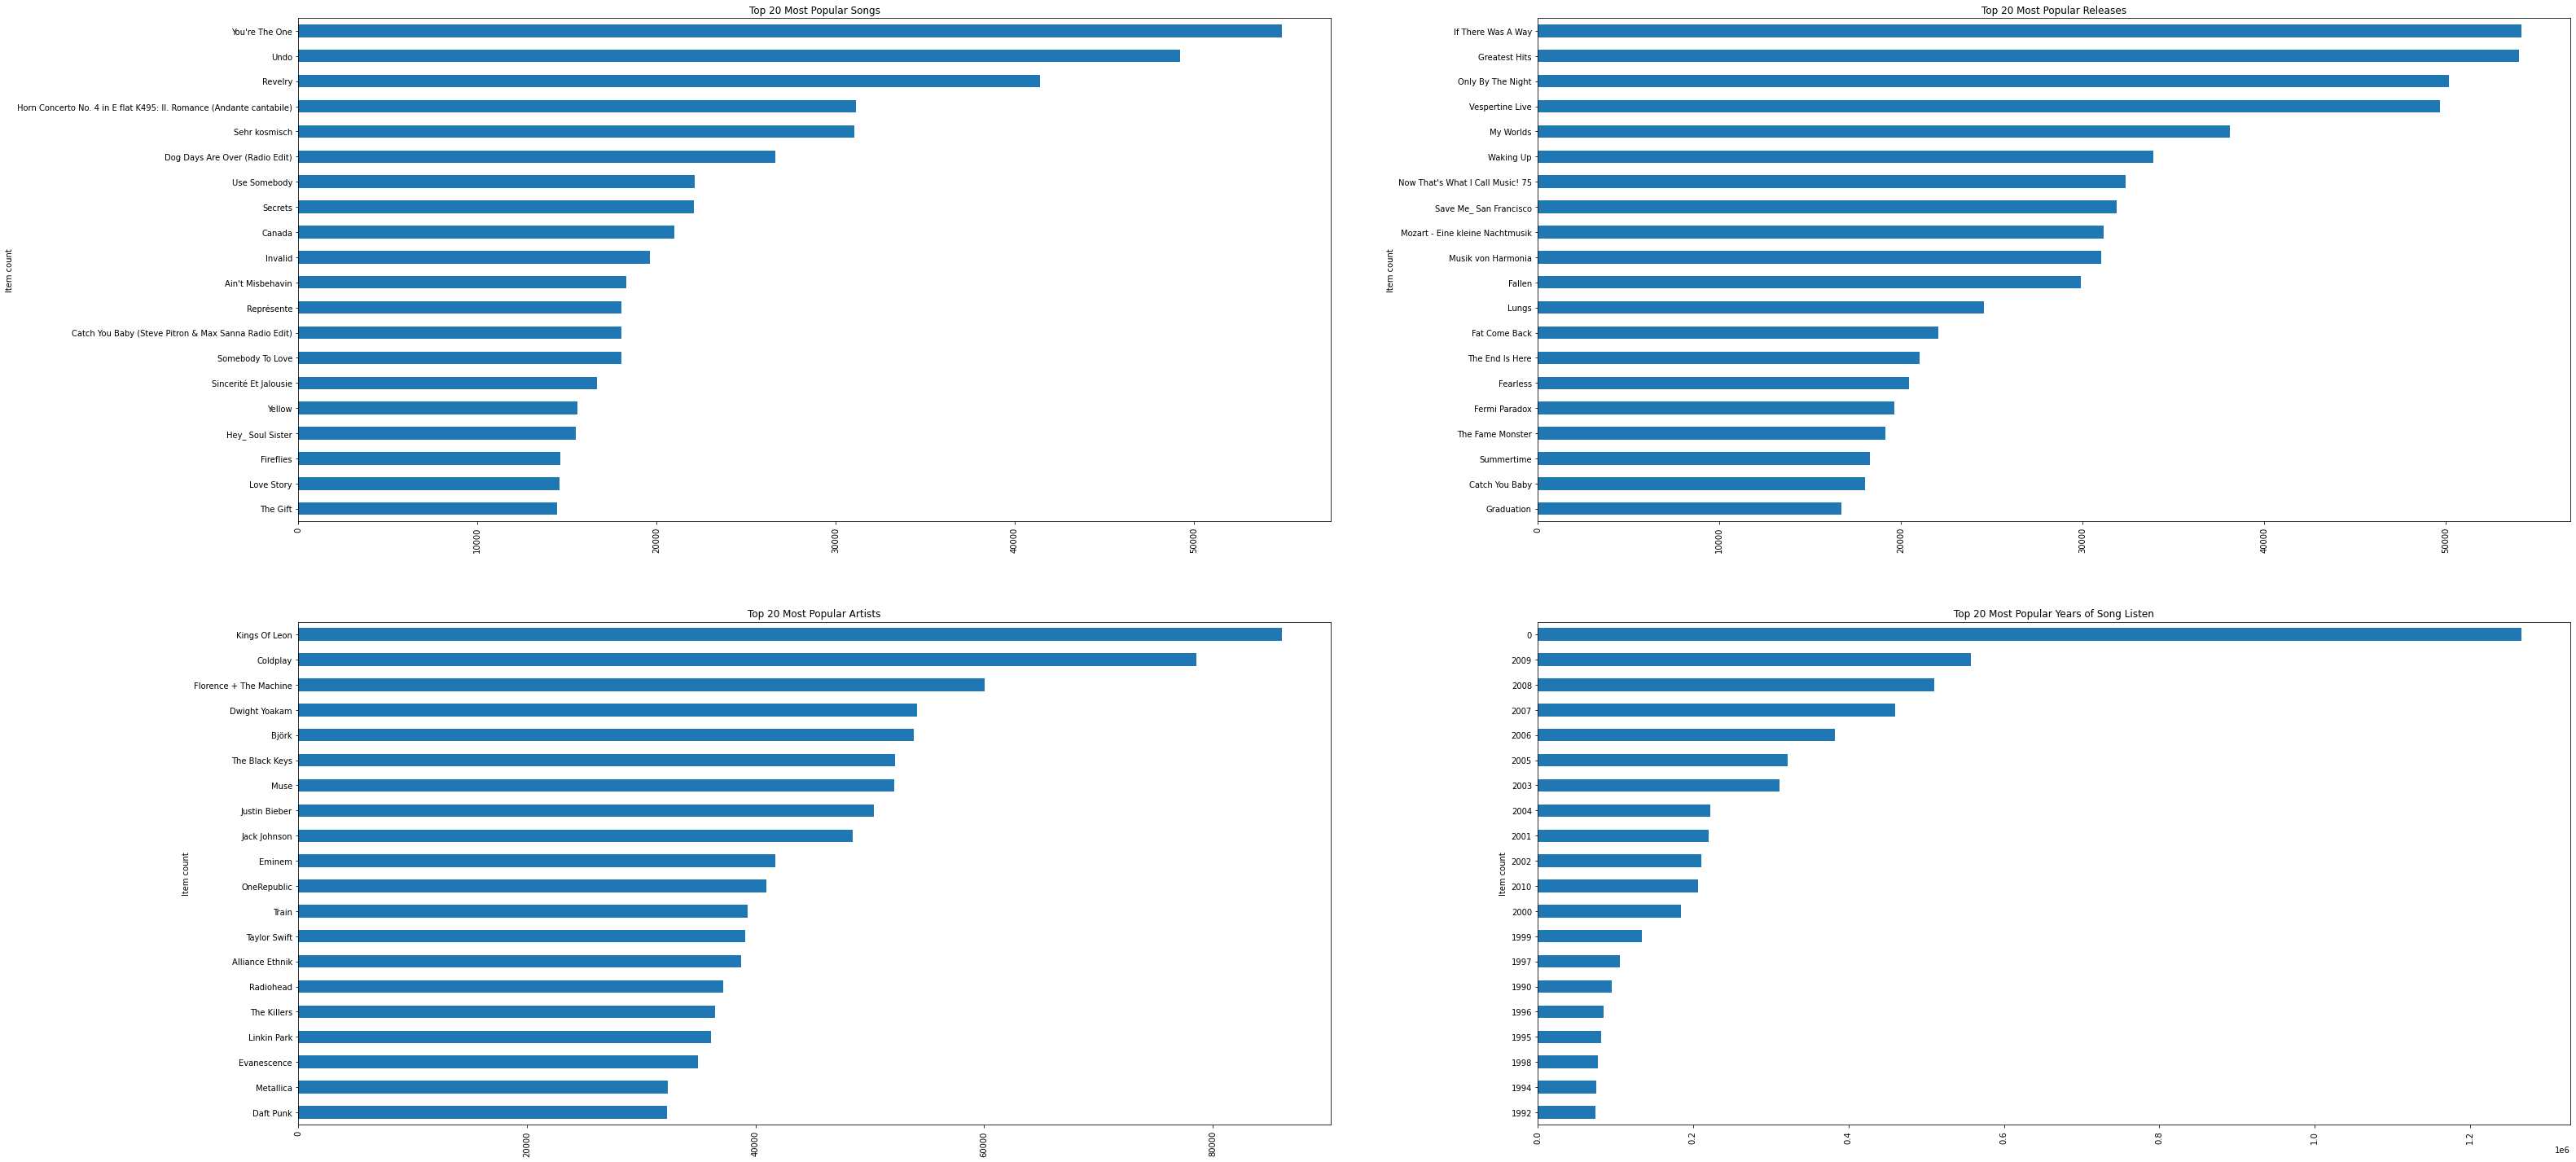

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(50, 25))
a1 = fig.add_subplot(221)
popular_songs = user_song_list_count[['title','listen_count']].groupby('title').sum().\
                sort_values('listen_count', ascending=False).head(20).sort_values('listen_count')
f1 = popular_songs.plot(kind='barh', title='Top 20 Most Popular Songs', legend=False, ax=a1)
plt.xticks(rotation='vertical')
plt.ylabel('Item count')

a2 = fig.add_subplot(222)
popular_release = user_song_list_count[['release','listen_count']].groupby('release').sum().\
                sort_values('listen_count', ascending=False).head(20).sort_values('listen_count')
f2 = popular_release.plot(kind='barh', title='Top 20 Most Popular Releases', legend=False, ax=a2)
plt.xticks(rotation='vertical')
plt.ylabel('Item count')

a3 = fig.add_subplot(223)
popular_artist = user_song_list_count[['artist_name','listen_count']].groupby('artist_name').sum().\
                sort_values('listen_count', ascending=False).head(20).sort_values('listen_count')
f1 = popular_artist.plot(kind='barh', title='Top 20 Most Popular Artists', legend=False, ax=a3)
plt.xticks(rotation='vertical')
plt.ylabel('Item count')

a4 = fig.add_subplot(224)
popular_year = user_song_list_count[['year','listen_count']].groupby('year').sum().\
                sort_values('listen_count', ascending=False).head(20).sort_values('listen_count')
f1 = popular_year.plot(kind='barh', title='Top 20 Most Popular Years of Song Listen', legend=False, ax=a4)
plt.xticks(rotation='vertical')
plt.ylabel('Item count')

plt.show()

In [ ]:
train_data, test_data = train_test_split(user_song_list_count_merged, test_size = 0.30, random_state=0)
(train_data.head(3))

,user,song,listen_count,title,release,artist_name,year,total_listen_count,fractional_play_count
1720363,edd62b0bf139a5064632c552bb7772ad2387fc96,SOXDHSF12A6BD4D3BD,36,Writer's Block,Overtones,Just Jack,2006,404,0.089109
1441119,7ede8b5cf33accf5397ceb6bc9b06a795338bbe3,SOBADLL12A6D4F8FEA,4,If You're Not The One,Gotta Get Thru This,Daniel Bedingfield,2002,17,0.235294
1109974,93f10d7bf7147aa2a783e0c3066b0462f9c16457,SOELORO12A8C1358DE,1,Throw Me A Rope,False Alarm EP,KT Tunstall,2004,760,0.001316


In [ ]:
import turicreate
train_data = turicreate.SFrame(train_data)
test_data = turicreate.SFrame(test_data)

**Popularity**

In [ ]:
popularity_model = turicreate.recommender.popularity_recommender.create(train_data, user_id='user', item_id='song', target='listen_count')

Warning: Ignoring columns title, release, artist_name, year, total_listen_count, fractional_play_count;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 1460862 observations with 75916 users and 10000 items.

Data prepared in: 2.15606s

1460862 observations to process; with 10000 unique items.

In [ ]:
popularity_model.evaluate_precision_recall(test_data)

recommendations finished on 1000/72713 queries. users per second: 3127.35

recommendations finished on 2000/72713 queries. users per second: 3153.54

recommendations finished on 3000/72713 queries. users per second: 3150.41

recommendations finished on 4000/72713 queries. users per second: 3145.75

recommendations finished on 5000/72713 queries. users per second: 3131.44

recommendations finished on 6000/72713 queries. users per second: 3132.86

recommendations finished on 7000/72713 queries. users per second: 3131.24

recommendations finished on 8000/72713 queries. users per second: 3132.32

recommendations finished on 9000/72713 queries. users per second: 3128.83

recommendations finished on 10000/72713 queries. users per second: 3141.8

recommendations finished on 11000/72713 queries. users per second: 3128.66

recommendations finished on 12000/72713 queries. users per second: 3123.92

recommendations finished on 13000/72713 queries. users per second: 3130.83

recommendations finished on 14000/72713 queries. users per second: 3118.87

recommendations finished on 15000/72713 queries. users per second: 3126.18

recommendations finished on 16000/72713 queries. users per second: 3132.58

recommendations finished on 17000/72713 queries. users per second: 3128.17

recommendations finished on 18000/72713 queries. users per second: 3130.5

recommendations finished on 19000/72713 queries. users per second: 3128.57

recommendations finished on 20000/72713 queries. users per second: 3117.24

recommendations finished on 21000/72713 queries. users per second: 3119.15

recommendations finished on 22000/72713 queries. users per second: 3117.32

recommendations finished on 23000/72713 queries. users per second: 3113.84

recommendations finished on 24000/72713 queries. users per second: 3110.8

recommendations finished on 25000/72713 queries. users per second: 3115.05

recommendations finished on 26000/72713 queries. users per second: 3118.66

recommendations finished on 27000/72713 queries. users per second: 3116.85

recommendations finished on 28000/72713 queries. users per second: 3120.09

recommendations finished on 29000/72713 queries. users per second: 3118.37

recommendations finished on 30000/72713 queries. users per second: 3110.15

recommendations finished on 31000/72713 queries. users per second: 3111.28

recommendations finished on 32000/72713 queries. users per second: 3111.49

recommendations finished on 33000/72713 queries. users per second: 3108.99

recommendations finished on 34000/72713 queries. users per second: 3107.6

recommendations finished on 35000/72713 queries. users per second: 3104.34

recommendations finished on 36000/72713 queries. users per second: 3104.49

recommendations finished on 37000/72713 queries. users per second: 3107.09

recommendations finished on 38000/72713 queries. users per second: 3109.41

recommendations finished on 39000/72713 queries. users per second: 3108.28

recommendations finished on 40000/72713 queries. users per second: 3108.8

recommendations finished on 41000/72713 queries. users per second: 3111.75

recommendations finished on 42000/72713 queries. users per second: 3111.2

recommendations finished on 43000/72713 queries. users per second: 3108.27

recommendations finished on 44000/72713 queries. users per second: 3111.29

recommendations finished on 45000/72713 queries. users per second: 3108.96

recommendations finished on 46000/72713 queries. users per second: 3103.56

recommendations finished on 47000/72713 queries. users per second: 3104.79

recommendations finished on 48000/72713 queries. users per second: 3104.45

recommendations finished on 49000/72713 queries. users per second: 3105.35

recommendations finished on 50000/72713 queries. users per second: 3104.81

recommendations finished on 51000/72713 queries. users per second: 3106.57

recommendations finished on 52000/72713 queries. users per second: 3106.32

recommendations finished on 53000/72713 queries. users per second: 3105.6

recommendations finished on 54000/72713 queries. users per second: 3104.16

recommendations finished on 55000/72713 queries. users per second: 3103.52

recommendations finished on 56000/72713 queries. users per second: 3105.62

recommendations finished on 57000/72713 queries. users per second: 3104.5

recommendations finished on 58000/72713 queries. users per second: 3100.75

recommendations finished on 59000/72713 queries. users per second: 3102.45

recommendations finished on 60000/72713 queries. users per second: 3104.01

recommendations finished on 61000/72713 queries. users per second: 3098.68

recommendations finished on 62000/72713 queries. users per second: 3100.37

recommendations finished on 63000/72713 queries. users per second: 3101.45

recommendations finished on 64000/72713 queries. users per second: 3100.78

recommendations finished on 65000/72713 queries. users per second: 3102.16

recommendations finished on 66000/72713 queries. users per second: 3102.19

recommendations finished on 67000/72713 queries. users per second: 3102.93

recommendations finished on 68000/72713 queries. users per second: 3101.44

recommendations finished on 69000/72713 queries. users per second: 3099.2

recommendations finished on 70000/72713 queries. users per second: 3101.18

recommendations finished on 71000/72713 queries. users per second: 3101.29

recommendations finished on 72000/72713 queries. users per second: 3101.68

{'precision_recall_by_user': Columns:
 	user	str
 	cutoff	int
 	precision	float
 	recall	float
 	count	int
 
 Rows: 1308834
 
 Data:
 +-------------------------------+--------+-----------+--------+-------+
 |              user             | cutoff | precision | recall | count |
 +-------------------------------+--------+-----------+--------+-------+
 | edd62b0bf139a5064632c552bb... |   1    |    0.0    |  0.0   |   26  |
 | edd62b0bf139a5064632c552bb... |   2    |    0.0    |  0.0   |   26  |
 | edd62b0bf139a5064632c552bb... |   3    |    0.0    |  0.0   |   26  |
 | edd62b0bf139a5064632c552bb... |   4    |    0.0    |  0.0   |   26  |
 | edd62b0bf139a5064632c552bb... |   5    |    0.0    |  0.0   |   26  |
 | edd62b0bf139a5064632c552bb... |   6    |    0.0    |  0.0   |   26  |
 | edd62b0bf139a5064632c552bb... |   7    |    0.0    |  0.0   |   26  |
 | edd62b0bf139a5064632c552bb... |   8    |    0.0    |  0.0   |   26  |
 | edd62b0bf139a5064632c552bb... |   9    |    0.0    |  0.0   |

In [ ]:
popularity_model.evaluate_rmse(train_data, target='listen_count')

RuntimeError: ignored

In [ ]:
popularity_model = popularity_model.recommend(users=list(range(1,3)),k=10)

for i in range(len(popularity_model)):
  if(popularity_model['song'][i] in (list(song_df['song_id']))):
    index = list(song_df['song_id']).index(popularity_model['song'][i])
    print(song_df['title'][index])
popularity_model.print_rows(num_rows=20)

Starshine
221
The Quest
Gestern_Morgen
Working With Homesick
Clara meets Slope - Hard To Say
Caroline
MIC (Speak Life Album Version)
Recado Falado (Metrô Da Saudade)
Hounds of Love (new mix)
Starshine
221
The Quest
Gestern_Morgen
Working With Homesick
Clara meets Slope - Hard To Say
Caroline
MIC (Speak Life Album Version)
Recado Falado (Metrô Da Saudade)
Hounds of Love (new mix)
+------+--------------------+--------------------+------+
| user |        song        |       score        | rank |
+------+--------------------+--------------------+------+
|  1   | SOFCGSE12AF72A674F | 25.45744680851064  |  1   |
|  1   | SOACBLB12AB01871C7 | 18.196428571428573 |  2   |
|  1   | SOZPMJT12AAF3B40D1 | 15.595238095238095 |  3   |
|  1   | SOXQIUR12A8AE4654A | 14.718446601941748 |  4   |
|  1   | SOGSDHY12AB017BF39 | 14.692307692307692 |  5   |
|  1   | SOJSXJY12A8C13E32E | 14.530054644808743 |  6   |
|  1   | SOAFPSO12AF72A4521 | 13.928571428571429 |  7   |
|  1   | SOQBUFQ12A6D4F7F4C | 13.44615

In [ ]:
def create_popularity_recommendation(songData, user, song):
    songDataGrouped = songData.groupby([song]).agg({user: 'count'}).reset_index()
    songDataGrouped.rename(columns = {user: 'score'},inplace=True)
    songDataSorted = songDataGrouped.sort_values(['score', song], ascending = [0,1])
    songDataSorted['Rank'] = songDataSorted['score'].rank(ascending=0, method='first')
    popularityBasedRecommendations = songDataSorted.head(10)
    return popularityBasedRecommendations

**Item based**

In [ ]:
item_sim_model = turicreate.item_similarity_recommender.create(train_data, user_id='user', item_id='song', target='listen_count', similarity_type='cosine')

Warning: Ignoring columns title, release, artist_name, year, total_listen_count, fractional_play_count;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 1460862 observations with 75916 users and 10000 items.

Data prepared in: 2.07995s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 6.155ms                        | 1.25       |

| 67.021ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 268.369ms                           | 0                | 0               |

| 3.01s                               | 100              | 10000           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 4.12234s

In [ ]:
item_sim_recomm = item_sim_model.recommend(users=[100],k=10)

for i in range(len(item_sim_recomm)):
  if(item_sim_recomm['song'][i] in (list(song_df['song_id']))):
    index = list(song_df['song_id']).index(item_sim_recomm['song'][i])
    print(song_df['title'][index])
item_sim_recomm.print_rows(num_rows=10)

Sehr kosmisch
Secrets
OMG
Supermassive Black Hole (Twilight Soundtrack Version)
Dog Days Are Over (Radio Edit)
Hey_ Soul Sister
Heartbreak Warfare
Love Story
Horn Concerto No. 4 in E flat K495: II. Romance (Andante cantabile)
The Scientist
+------+--------------------+----------------------+------+
| user |        song        |        score         | rank |
+------+--------------------+----------------------+------+
| 100  | SOFRQTD12A81C233C0 | 0.01054956078529358  |  1   |
| 100  | SONYKOW12AB01849C9 | 0.010125592947006226 |  2   |
| 100  | SOUSMXX12AB0185C24 | 0.009257566928863526 |  3   |
| 100  | SOIZLKI12A6D4F7B61 |  0.0086257004737854  |  4   |
| 100  | SOAXGDH12A8C13F8A1 | 0.00831252932548523  |  5   |
| 100  | SODJWHY12A8C142CCE | 0.008293513059616089 |  6   |
| 100  | SOUFPNI12A8C142D19 | 0.008132596015930176 |  7   |
| 100  | SOTWSXL12A8C143349 | 0.007302753925323487 |  8   |
| 100  | SOEGIYH12A6D4FC0E3 | 0.007162244319915772 |  9   |
| 100  | SOKLRPJ12A8C13C3FE | 0.00701488

In [ ]:
item_sim_model.evaluate_rmse(test_data, target='listen_count')

{'rmse_by_item': Columns:
 	song	str
 	rmse	float
 	count	int
 
 Rows: 10000
 
 Data:
 +--------------------+--------------------+-------+
 |        song        |        rmse        | count |
 +--------------------+--------------------+-------+
 | SOOIROS12A8C13C802 | 1.3887455272203217 |   28  |
 | SOLASAK12A58A7DB32 | 2.4788987468466286 |   13  |
 | SOXOXQA12AF72ABF5B | 4.904370459727622  |   38  |
 | SOMLQGF12AB0184C2A | 5.621956796138479  |   62  |
 | SOTTTEQ12B0B80CA01 | 6.6821919076586624 |   96  |
 | SOUGOHW12AB018AEA3 | 8.769512267320687  |  129  |
 | SOBSLVH12A8C131F38 | 7.8921494170143855 |  199  |
 | SOCBGZW12A58A7CAC2 | 4.672695229678377  |   66  |
 | SOCJWZY12A67021D18 | 5.910171522280932  |  182  |
 | SOCEWMO12A8151CBDE | 4.478684333662327  |  100  |
 +--------------------+--------------------+-------+
 [10000 rows x 3 columns]
 Note: Only the head of the SFrame is printed.
 You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.,
 'rmse_by_user'

**factorization_recommender**

In [ ]:
fact_model = turicreate.recommender.ranking_factorization_recommender.create(train_data,
                                          user_id='user',
                                    item_id='song',
                                    target='listen_count')
results = fact_model.recommend(k=3)


Preparing data set.

Data has 1460862 observations with 75916 users and 10000 items.

Data prepared in: 4.85346s

Training ranking_factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 32       |

| regularization                 | L2 Regularization on Factors                     | 1e-09    |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-09    |

| ranking_regularization         | Rank-based Regularization Weight                 | 0.25     |

| max_iterations                 | Maximum Number of Iterations                     | 25       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 182607 / 1460862 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 6.25              | Not Viable                               |

| 1       | 1.5625            | Not Viable                               |

| 2       | 0.390625          | Not Viable                               |

| 3       | 0.0976562         | Not Viable                               |

| 4       | 0.0244141         | No Decrease (97.1643 >= 82.3641)         |

| 5       | 0.00610352        | No Decrease (100.754 >= 82.3641)         |

| 6       | 0.00152588        | 75.2989                                  |

| 7       | 0.000762939       | 80.5964                                  |

| 8       | 0.00038147        | 81.8745                                  |

| 9       | 0.000190735       | 81.9789                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00152588        | 75.2989                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 95us         | 85.3124           | 6.59668               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 8.10s        | 80.3845           | 6.6658                | 0.00152588  |

| 2       | 16.05s       | 77.4144           | 6.76429               | 0.00152588  |

| 3       | 23.95s       | 80.0055           | 7.02064               | 0.00152588  |

| 4       | 31.80s       | 80.4933           | 7.1168                | 0.00152588  |

| 5       | 39.58s       | 86.5801           | 7.47342               | 0.00152588  |

| 7       | 54.98s       | 100.803           | 8.26167               | 0.00152588  |

| 8       | 1m 2s        | 103.533           | 8.44643               | 0.00152588  |

| 9       | 1m 10s       | 118.6             | 9.16185               | 0.00152588  |

| 10      | 1m 20s       | DIVERGED          | DIVERGED              | 0.00152588  |

| RESET   | 1m 23s       | 85.3134           | 6.59677               |             |

| 1       | 1m 31s       | 82.2109           | 6.60788               | 0.000762939 |

| 2       | 1m 39s       | 79.2375           | 6.62369               | 0.000762939 |

| 3       | 1m 47s       | 78.3427           | 6.68603               | 0.000762939 |

| 4       | 1m 54s       | 79.203            | 6.80339               | 0.000762939 |

| 5       | 2m 2s        | 80.736            | 6.93634               | 0.000762939 |

| 6       | 2m 10s       | 82.5695           | 7.07851               | 0.000762939 |

| 7       | 2m 18s       | 84.6391           | 7.22674               | 0.000762939 |

| 8       | 2m 25s       | 87.1039           | 7.38815               | 0.000762939 |

| 9       | 2m 33s       | 88.9493           | 7.51206               | 0.000762939 |

| 10      | 2m 41s       | 92.0865           | 7.69472               | 0.000762939 |

| 11      | 2m 49s       | 93.349            | 7.77889               | 0.000762939 |

| 12      | 2m 57s       | 95.5875           | 7.90729               | 0.000762939 |

| 13      | 3m 7s        | DIVERGED          | DIVERGED              | 0.000762939 |

| RESET   | 3m 11s       | 85.3123           | 6.59671               |             |

| 1       | 3m 18s       | 83.9579           | 6.59312               | 0.00038147  |

| 2       | 3m 26s       | 82.7582           | 6.59687               | 0.00038147  |

| 3       | 3m 34s       | 81.9189           | 6.60189               | 0.00038147  |

| 4       | 3m 41s       | 81.1307           | 6.60506               | 0.00038147  |

| 5       | 3m 49s       | 80.3641           | 6.60648               | 0.00038147  |

| 6       | 3m 57s       | 79.7106           | 6.60825               | 0.00038147  |

| 7       | 4m 5s        | 79.1951           | 6.61234               | 0.00038147  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached (hard limit).

Computing final objective value and training RMSE.

Final objective value: 78.9899

Final training RMSE: 6.61691

recommendations finished on 1000/75916 queries. users per second: 1139.59

recommendations finished on 2000/75916 queries. users per second: 1131.58

recommendations finished on 3000/75916 queries. users per second: 1132.22

recommendations finished on 4000/75916 queries. users per second: 1130.67

recommendations finished on 5000/75916 queries. users per second: 1129.73

recommendations finished on 6000/75916 queries. users per second: 1129.26

recommendations finished on 7000/75916 queries. users per second: 1128.74

recommendations finished on 8000/75916 queries. users per second: 1129.34

recommendations finished on 9000/75916 queries. users per second: 1126.42

recommendations finished on 10000/75916 queries. users per second: 1126.81

recommendations finished on 11000/75916 queries. users per second: 1125.66

recommendations finished on 12000/75916 queries. users per second: 1125.5

recommendations finished on 13000/75916 queries. users per second: 1124.93

recommendations finished on 14000/75916 queries. users per second: 1124.74

recommendations finished on 15000/75916 queries. users per second: 1125.78

recommendations finished on 16000/75916 queries. users per second: 1124.75

recommendations finished on 17000/75916 queries. users per second: 1124.07

recommendations finished on 18000/75916 queries. users per second: 1123.24

recommendations finished on 19000/75916 queries. users per second: 1124.33

recommendations finished on 20000/75916 queries. users per second: 1124.25

recommendations finished on 21000/75916 queries. users per second: 1123.97

recommendations finished on 22000/75916 queries. users per second: 1123.66

recommendations finished on 23000/75916 queries. users per second: 1124.47

recommendations finished on 24000/75916 queries. users per second: 1124.85

recommendations finished on 25000/75916 queries. users per second: 1124.84

recommendations finished on 26000/75916 queries. users per second: 1124.98

recommendations finished on 27000/75916 queries. users per second: 1125.63

recommendations finished on 28000/75916 queries. users per second: 1125.56

recommendations finished on 29000/75916 queries. users per second: 1125.84

recommendations finished on 30000/75916 queries. users per second: 1126.24

recommendations finished on 31000/75916 queries. users per second: 1126.41

recommendations finished on 32000/75916 queries. users per second: 1126.3

recommendations finished on 33000/75916 queries. users per second: 1126.69

recommendations finished on 34000/75916 queries. users per second: 1126.54

recommendations finished on 35000/75916 queries. users per second: 1126.23

recommendations finished on 36000/75916 queries. users per second: 1125.99

recommendations finished on 37000/75916 queries. users per second: 1125.51

recommendations finished on 38000/75916 queries. users per second: 1125.02

recommendations finished on 39000/75916 queries. users per second: 1124.43

recommendations finished on 40000/75916 queries. users per second: 1124.08

recommendations finished on 41000/75916 queries. users per second: 1123.75

recommendations finished on 42000/75916 queries. users per second: 1123.63

recommendations finished on 43000/75916 queries. users per second: 1123.26

recommendations finished on 44000/75916 queries. users per second: 1123.02

recommendations finished on 45000/75916 queries. users per second: 1123.02

recommendations finished on 46000/75916 queries. users per second: 1122.56

recommendations finished on 47000/75916 queries. users per second: 1122.58

recommendations finished on 48000/75916 queries. users per second: 1122.49

recommendations finished on 49000/75916 queries. users per second: 1122.31

recommendations finished on 50000/75916 queries. users per second: 1122.41

recommendations finished on 51000/75916 queries. users per second: 1122.69

recommendations finished on 52000/75916 queries. users per second: 1122.51

recommendations finished on 53000/75916 queries. users per second: 1122.4

recommendations finished on 54000/75916 queries. users per second: 1122.73

recommendations finished on 55000/75916 queries. users per second: 1123.23

recommendations finished on 56000/75916 queries. users per second: 1123.48

recommendations finished on 57000/75916 queries. users per second: 1123.75

recommendations finished on 58000/75916 queries. users per second: 1124.29

recommendations finished on 59000/75916 queries. users per second: 1124.82

recommendations finished on 60000/75916 queries. users per second: 1125.08

recommendations finished on 61000/75916 queries. users per second: 1125.8

recommendations finished on 62000/75916 queries. users per second: 1126.08

recommendations finished on 63000/75916 queries. users per second: 1126.41

recommendations finished on 64000/75916 queries. users per second: 1126.79

recommendations finished on 65000/75916 queries. users per second: 1127.1

recommendations finished on 66000/75916 queries. users per second: 1127.47

recommendations finished on 67000/75916 queries. users per second: 1127.65

recommendations finished on 68000/75916 queries. users per second: 1127.94

recommendations finished on 69000/75916 queries. users per second: 1128.13

recommendations finished on 70000/75916 queries. users per second: 1128.63

recommendations finished on 71000/75916 queries. users per second: 1128.85

recommendations finished on 72000/75916 queries. users per second: 1129.2

recommendations finished on 73000/75916 queries. users per second: 1129.37

recommendations finished on 74000/75916 queries. users per second: 1129.64

recommendations finished on 75000/75916 queries. users per second: 1129.53

In [ ]:
results = fact_model.recommend(users=[100], k=10)

for i in range(len(results)):
  if(results['song'][i] in (list(song_df['song_id']))):
    index = list(song_df['song_id']).index(results['song'][i])
    print(song_df['title'][index])
results.print_rows(num_rows=10)

Sehr kosmisch
You're The One
Dog Days Are Over (Radio Edit)
Undo
Revelry
Supermassive Black Hole (Twilight Soundtrack Version)
Horn Concerto No. 4 in E flat K495: II. Romance (Andante cantabile)
Hey_ Soul Sister
Billionaire [feat. Bruno Mars]  (Explicit Album Version)
Canada
+------+--------------------+--------------------+------+
| user |        song        |       score        | rank |
+------+--------------------+--------------------+------+
| 100  | SOFRQTD12A81C233C0 | 3.0754465613086466 |  1   |
| 100  | SOBONKR12A58A7A7E0 | 3.0670548233707193 |  2   |
| 100  | SOAXGDH12A8C13F8A1 | 3.066875581028009  |  3   |
| 100  | SOAUWYT12A81C206F1 | 3.065289378495956  |  4   |
| 100  | SOSXLTC12AF72A7F54 | 3.0609028715212587 |  5   |
| 100  | SOIZLKI12A6D4F7B61 | 3.0606270473022703 |  6   |
| 100  | SOEGIYH12A6D4FC0E3 | 3.056881646024132  |  7   |
| 100  | SODJWHY12A8C142CCE | 3.0544256124217752 |  8   |
| 100  | SOPTLQL12AB018D56F | 3.0535880479533914 |  9   |
| 100  | SOPUCYA12A8C13A694 

In [ ]:
fact_model.evaluate_rmse(test_data, target='listen_count')

{'rmse_by_item': Columns:
 	song	str
 	rmse	float
 	count	int
 
 Rows: 10000
 
 Data:
 +--------------------+--------------------+-------+
 |        song        |        rmse        | count |
 +--------------------+--------------------+-------+
 | SOOIROS12A8C13C802 | 1.6287275625254087 |   28  |
 | SOLASAK12A58A7DB32 | 1.472959776927177  |   13  |
 | SOXOXQA12AF72ABF5B | 7.552250820308212  |   38  |
 | SOMLQGF12AB0184C2A | 5.1060624967709165 |   62  |
 | SOTTTEQ12B0B80CA01 | 6.141913662418871  |   96  |
 | SOUGOHW12AB018AEA3 | 8.341070409739974  |  129  |
 | SOBSLVH12A8C131F38 | 7.882664459330724  |  199  |
 | SOCBGZW12A58A7CAC2 |  8.17067204794137  |   66  |
 | SOCJWZY12A67021D18 |  5.35279070972721  |  182  |
 | SOCEWMO12A8151CBDE | 3.974896752215731  |  100  |
 +--------------------+--------------------+-------+
 [10000 rows x 3 columns]
 Note: Only the head of the SFrame is printed.
 You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.,
 'rmse_by_user'

In [ ]:
fact_model.

<bound method Model.summary of Class                            : RankingFactorizationRecommender

Schema
------
User ID                          : user
Item ID                          : song
Target                           : listen_count
Additional observation features  : 6
User side features               : []
Item side features               : []

Statistics
----------
Number of observations           : 1460862
Number of users                  : 75916
Number of items                  : 10000

Training summary
----------------
Training time                    : 290.53

Model Parameters
----------------
Model class                      : RankingFactorizationRecommender
num_factors                      : 32
binary_target                    : 0
side_data_factorization          : 1
solver                           : auto
nmf                              : 0
max_iterations                   : 25

Regularization Settings
-----------------------
regularization                   : 0.0
regu

In [ ]:
def join_titles(sframe,on):
    return sframe.join(right=train_data, on=on, how='inner')
results = join_titles(results,'song')
results.sort(['user','rank'], ascending=True).print_rows(20)


**SVD**

In [ ]:
from surprise import SVD
from surprise.model_selection import GridSearchCV

In [ ]:
user_counts = triplets.groupby('user')['song'].count()

# Filter users which have listen to at least 16 songs
user_ten_id = user_counts[user_counts > 16].index.to_list()

song_counts = triplets.groupby('song')['user'].count()

# Get songs which have been listened at least 4 times
song_ten_id = song_counts[song_counts > 200].index.to_list()

In [ ]:
param_grid = {'n_factors': [160], 'n_epochs': [100], 'lr_all': [0.001, 0.005],'reg_all': [0.08, 0.1]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)
algo = gs.best_estimator['rmse']
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

#Assigning values
t = gs.best_params
factors = t['rmse']['n_factors']
epochs = t['rmse']['n_epochs']
lr_value = t['rmse']['lr_all']
reg_value = t['rmse']['reg_all']

In [ ]:
reader = Reader(rating_scale=(1, 10))
df_song_reduced = triplets[(triplets['user'].isin(user_ten_id)) & (triplets['song'].isin(song_ten_id))].reset_index(drop=True)
data = Dataset.load_from_df(df_song_reduced[['user', 'song', 'play_count']], reader)
# n_factors=factors, n_epochs=epochs, lr_all=lr_value, reg_all=reg_value
trainset = data.build_full_trainset()   
algo = SVD()
algo.fit(trainset)

In [ ]:
# Predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()

#Predicting the ratings for testset
predictions = algo.test(testset)

In [ ]:
from surprise.model_selection import GridSearchCV
from surprise import SVD

grid_search_svd = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, joblib_verbose=4, n_jobs=-2)

In [ ]:
user_songs = train_data[['total_listen_count', 'fractional_play_count', 'listen_count']].to_numpy() 
user_songs[3]

array([1.50000000e+02, 4.66666667e-02, 7.00000000e+00])

In [ ]:
reader = Reader(line_format='user item rating timestamp', sep='\t')
data = pd.read_csv('https://static.turi.com/datasets/millionsong/10000.txt', reader=reader)

In [ ]:
song_user = triplets.groupby('song')['user'].count()


In [ ]:
user_counts = triplets.groupby('user')['song'].count()

# Filter users which have listen to at least 16 songs
user_ten_id = user_counts[user_counts > 16].index.to_list()

In [ ]:
song_counts = triplets.groupby('song')['user'].count()

# Get songs which have been listened at least 4 times
song_ten_id = song_counts[song_counts > 200].index.to_list()

In [ ]:
df_song_reduced = triplets[(triplets['user'].isin(user_ten_id)) & (triplets['song'].isin(song_ten_id))].reset_index(drop=True)


In [ ]:
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(df_song_reduced[['user', 'song', 'play_count']], reader)


In [ ]:
load_movies_list = saveLoadFile.loadClusterMoviesDataset()

In [ ]:
import pickle as pickle
song_id_name_dic = pickle.load(open("/content/sample_data/clusters_movies_dataset.pkl","rb"))

In [ ]:
from surprise import NMF

algo = SVD()
trainset = data.build_full_trainset()
algo.fit(trainset)
predict = []
user_inner_id = 12
user_rating = trainset.ur[user_inner_id]
items = map(lambda x:x[0], user_rating)
for song in items:
  predict = algo.predict(algo.trainset.to_raw_uid(user_inner_id), algo.trainset.to_raw_iid(song), r_ui=1)
  if(predict.iid in list(song_df['song_id'])):
    index = list(song_df['song_id']).index(predict.iid)
    print(song_df['title'][index])


Down On The Corner
Surfin' Bird
In The Flesh
Do We Need This?
On A Plain
Yesterday Once More
Flake
She Moves In Her Own Way
'Round Midnight
California Dreamin'


In [ ]:
from surprise import accuracy
testset = trainset.build_anti_testset()
train_predictions = algo.test(testset)
print("RMSE on training data : ", accuracy.rmse(predictions, verbose = False))